In [1]:
import pandas as pd

df = pd.read_csv("logs.csv.gz", compression="gzip", parse_dates=[1])

In [2]:
len(df)

3302930

In [3]:
df.dtypes

ogpweb#               int64
date         datetime64[ns]
request              object
code                  int64
bytes                 int64
referrer             object
useragent            object
source               object
rt                  float64
urt                 float64
dtype: object

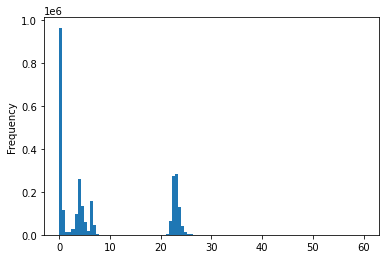

In [236]:
ax = df['urt'].plot.hist(bins=100, range=[0,60])

In [186]:
def bucket(r):
    r = r.rsplit('HTTP/')[0].split('GET ')[-1]
    for s in ('?', '/dataset/', '/reference/', '/inventory/',
              '/comment/', '/node/', '/suggested-datasets/',
              '/4plan/', '/apps/'):
        if s in r:
            r = r.split(s)[0] + s + '…'
    return r
bdf = df[['request','urt']].copy(deep=True)
bdf['request'] = bdf['request'].map(bucket)

In [307]:
days_budget = 4 * 8 * 2 * 7
days_budget

448

In [333]:
sdf['urt_sum'].sum()

266.23375013888403

In [190]:
sdf = bdf.groupby(['request']).agg(['median','count','sum'])
sdf.columns = sdf.columns.map('_'.join)
sdf['urt_sum'] = sdf['urt_sum'] / (60*60*24)  # days

busy = sdf[(sdf['urt_count'] > 10) & (sdf['urt_sum'] > 0.02)]
busy.sort_values('urt_sum', ascending=False).rename(
    columns={'urt_sum':'urt_sum (days)'})

,urt_median,urt_count,urt_sum (days)
request,,,
/fr/search/travelq?…,22.7220,1028923,233.496984
/en/search/contracts?…,4.0300,136004,6.528421
/en/search/travelq?…,4.3240,102373,5.248754
/en/search/hospitalityq?…,4.0450,91415,4.430040
/en/search/ati?…,3.1460,114572,4.187813
/en/search/reclassification?…,4.2070,79139,3.850433
/data/en/dataset?…,0.4190,450957,2.375996
/fr/search/contrats?…,5.3910,15266,0.979683
/fr/search/hospitalityq?…,4.9610,15637,0.912061


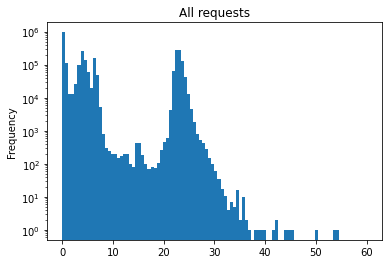

In [228]:
ax = df['urt'].plot.hist(
    bins=100, log=True, range=[0,60], title="All requests")

In [234]:
df['search'] = df['urt'].notna() & df['request'].str.contains(r'/(?:od|bn|ct|ei|gc|nap|si|qp|sd)/')
df['ckan'] = df['urt'].notna() & df['request'].str.contains(' /data/')
df['drupal'] = df['urt'].notna() & ~ df['search'] & ~ df['ckan']

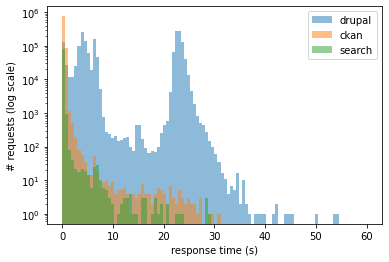

In [235]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.hist(df[df['drupal']]['urt'], alpha=0.5, log=True, bins=100, range=[0,60],  label='drupal')
ax.hist(df[df['ckan']]['urt'], alpha=0.5, log=True, bins=100, range=[0,60],  label='ckan')
ax.hist(df[df['search']]['urt'], alpha=0.5, log=True, bins=100, range=[0,60], label='search')
ax.legend(loc='upper right')
ax.set_ylabel('# requests (log scale)')
ax.set_xlabel('response time (s)')
plt.show()

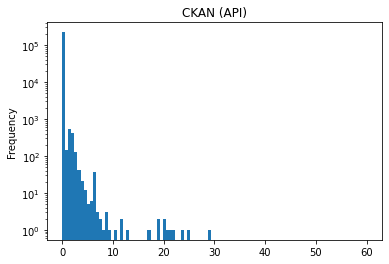

In [237]:
ax = df[df['request'].str.contains('/action/')]['urt'].plot.hist(
    bins=100, log=True, range=[0,60], title="CKAN (API)")

In [238]:
cadf = df[df['request'].str.contains('/action/')][
    ['request','urt']].copy(deep=True)
cadf['request'] = cadf['request'].str.extract(r'/action/(\w+)')

In [239]:
scadf = cadf.groupby(['request']).agg(['median','count','sum'])
scadf.columns = scadf.columns.map('_'.join)
scadf['urt_sum'] = scadf['urt_sum'] / 60  # minutes
scadf.sort_values('urt_sum', ascending=False).rename(
    columns={'urt_sum':'urt_sum (minutes)'})

,urt_median,urt_count,urt_sum (minutes)
request,,,
package_show,0.0370,220655,154.206817
package_update,1.9355,716,24.455150
package_search,0.3450,2501,23.927400
organization_list,6.2510,29,3.037117
package_create,5.3930,5,0.447067
package_list,1.4200,7,0.170833
recently_changed_packages_activity_list,0.1465,20,0.050267
help_show,0.0160,5,0.001317


In [288]:
import heapq
from datetime import datetime, timedelta

def csim(expire):
    h = []
    c = set()
    def lookup(row):
        dt = row['date']
        req = row['request']
        while h and h[0][0] + expire < dt:
            c.remove(h[0][1])
            heapq.heappop(h)
        if req in c:
            return True
        heapq.heappush(h, (dt, req))
        c.add(req)
        return False
    return lookup

In [270]:
cdf = df[df['urt'].notna() & df['request'].str.match('GET ')][
    ['ogpweb#','date','request','urt']].copy(deep=True)
cdf.sort_values(by='date', inplace=True)

In [ ]:
cdf['1dhit'] = cdf.apply(csim(timedelta(days=1)), axis=1)

In [326]:
s = cdf[cdf['1dhit']][['urt']].sum()
print("%0.2f hours" % (s / 60 / 60))
print("%0.2f %% savings" % (s / 60 / 60 / 24 / days_budget * 100))

66.22 hours
0.62 % savings


In [293]:
cdf['5mhit'] = cdf.apply(csim(timedelta(minutes=5)), axis=1)

In [327]:
s = cdf[cdf['5mhit']][['urt']].sum()
print("%0.2f hours" % (s / 60 / 60))
print("%0.2f %% savings" % (s / 60 / 60 / 24 / days_budget * 100))

10.01 hours
0.09 % savings


In [328]:
cdf[(cdf['date'] > datetime(2020,9,4,1,1,1)) &
    (cdf['date'] < datetime(2020,9,4,1,1,10))]

,ogpweb#,date,request,urt,1dhit,5mhit
107982,1,2020-09-04 01:01:02,GET /fr/search/travelq?f[0]=:Tribunal des anci...,23.327,False,False
107981,1,2020-09-04 01:01:02,GET /en/search/ati?ati[0]=:Privy Council Offic...,4.131,False,False
107979,1,2020-09-04 01:01:02,GET /en/external-comment/dataset/90a31d6a-9131...,0.702,False,False
2586662,4,2020-09-04 01:01:02,GET /data/en/dataset?organization=esdc-edsc&su...,0.947,False,False
1761825,3,2020-09-04 01:01:02,GET /en/vote?uuid=90a31d6a-9131-4f31-a156-cd1f...,0.870,False,False
933836,2,2020-09-04 01:01:02,GET /data/fr/dataset?keywords_fra=Programme de...,0.165,False,False
107985,1,2020-09-04 01:01:03,GET /en/search/ati?ati[0]=:Privy Council Offic...,4.243,False,False
107984,1,2020-09-04 01:01:03,GET /data/en/dataset?keywords_frari/=&_keyword...,0.295,True,False
2586664,4,2020-09-04 01:01:03,GET /en/search/reclassification?reclassificati...,4.145,False,False
933840,2,2020-09-04 01:01:03,GET /en/search/ati?ati[0]=:Privy Council Offic...,3.945,False,False


In [4]:
ccdf = df[df['request'].str.contains('/search/contra')][['request','urt']][df['urt'].notna()].copy()

/home/ian/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [1]:
#pd.options.display.max_colwidth = 1000
#pd.options.display.max_rows = 500
#ccdf.sort_values('urt')